In [ ]:
import pandas as pd

df = pd.read_csv("/content/Fake_news_content_detection.csv")
df.head()


,Unnamed: 0,Text,Text_Tag,Barely-True,False,Half-True,Mostly-True,Not-Known,True
0,0,Says the Annies List political group supports ...,abortion,0,1,0,0,0,0
1,1,When did the decline of coal start? It started...,"energy,history,job-accomplishments",0,0,1,0,0,0
2,2,"Hillary Clinton agrees with John McCain ""by vo...",foreign-policy,0,0,0,1,0,0
3,3,Health care reform legislation is likely to ma...,health-care,0,1,0,0,0,0
4,4,The economic turnaround started at the end of ...,"economy,jobs",0,0,1,0,0,0


In [ ]:
df.columns


Index(['Unnamed: 0', 'Text', 'Text_Tag', 'Barely-True', 'False', 'Half-True',
       'Mostly-True', 'Not-Known', 'True'],
      dtype='object')

In [ ]:
df = df.drop(columns=['Unnamed: 0'])


In [ ]:
def create_label(row):
    if row['False'] == 1 or row['Barely-True'] == 1 or row['Not-Known'] == 1:
        return 0
    else:
        return 1

df['label'] = df.apply(create_label, axis=1)


In [ ]:
df = df[['Text', 'label']]
df.head()


,Text,label
0,Says the Annies List political group supports ...,0
1,When did the decline of coal start? It started...,1
2,"Hillary Clinton agrees with John McCain ""by vo...",1
3,Health care reform legislation is likely to ma...,0
4,The economic turnaround started at the end of ...,1


In [ ]:
df['label'].value_counts()


,count
label,
1,5752
0,4488


In [ ]:
import re
import nltk
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer

nltk.download('stopwords')

stop_words = set(stopwords.words('english'))

def clean_text(text):
    text = text.lower()
    text = re.sub(r'http\S+|www\S+', '', text)
    text = re.sub(r'[^a-z\s]', '', text)
    words = text.split()
    words = [w for w in words if w not in stop_words]
    return " ".join(words)

df['clean_text'] = df['Text'].apply(clean_text)


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
X = df['clean_text']
y = df['label']

tfidf = TfidfVectorizer(max_features=5000)
X = tfidf.fit_transform(X)


In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)


In [ ]:
from sklearn.linear_model import LogisticRegression

log_model = LogisticRegression(max_iter=1000)
log_model.fit(X_train, y_train)


LogisticRegression(max_iter=1000)

In [ ]:
from sklearn.metrics import accuracy_score, classification_report

y_pred_log = log_model.predict(X_test)

print("Logistic Regression Accuracy:", accuracy_score(y_test, y_pred_log))
print(classification_report(y_test, y_pred_log))


Logistic Regression Accuracy: 0.599609375
              precision    recall  f1-score   support

           0       0.55      0.43      0.48       888
           1       0.63      0.73      0.67      1160

    accuracy                           0.60      2048
   macro avg       0.59      0.58      0.58      2048
weighted avg       0.59      0.60      0.59      2048



In [ ]:
from sklearn.naive_bayes import MultinomialNB

nb_model = MultinomialNB()
nb_model.fit(X_train, y_train)


MultinomialNB()

In [ ]:
y_pred_nb = nb_model.predict(X_test)

print("Naive Bayes Accuracy:", accuracy_score(y_test, y_pred_nb))
print(classification_report(y_test, y_pred_nb))


Naive Bayes Accuracy: 0.59814453125
              precision    recall  f1-score   support

           0       0.56      0.36      0.44       888
           1       0.61      0.78      0.69      1160

    accuracy                           0.60      2048
   macro avg       0.59      0.57      0.56      2048
weighted avg       0.59      0.60      0.58      2048



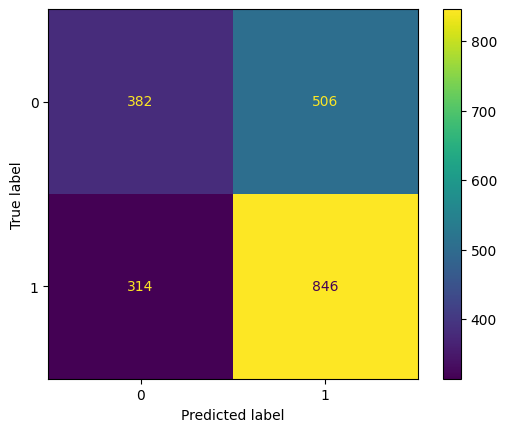

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

cm = confusion_matrix(y_test, y_pred_log)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.show()


In [ ]:
from sklearn.model_selection import cross_val_score

cv_scores = cross_val_score(log_model, X, y, cv=5, scoring='accuracy')

print("Cross-validation scores:", cv_scores)
print("Average CV accuracy:", cv_scores.mean())


Cross-validation scores: [0.60351562 0.61132812 0.59521484 0.60693359 0.59912109]
Average CV accuracy: 0.60322265625


In [ ]:
import pickle

with open("fake_news_model_new.pkl", "wb") as f:
    pickle.dump(log_model, f)

with open("tfidf_vectorizer_new.pkl", "wb") as f:
    pickle.dump(tfidf, f)


In [ ]:
with open("fake_news_model_new.pkl", "rb") as f:
    loaded_model = pickle.load(f)

with open("tfidf_vectorizer_new.pkl", "rb") as f:
    loaded_tfidf = pickle.load(f)


In [ ]:
def predict_news_new(news_text):
    cleaned = clean_text(news_text)
    vector = loaded_tfidf.transform([cleaned])
    pred = loaded_model.predict(vector)
    return "FAKE NEWS" if pred[0] == 0 else "REAL NEWS"


In [ ]:
print(predict_news_new(
    "Scientists claim that drinking lemon water cures all diseases instantly"
))

print(predict_news_new(
    "The Indian Space Research Organisation launched a communication satellite successfully"
))


REAL NEWS
REAL NEWS


In [ ]:
%%writefile app_new.py
import streamlit as st
import pickle
import re
import nltk
from nltk.corpus import stopwords

nltk.download('stopwords')

# Load new dataset model & vectorizer
with open("fake_news_model_new.pkl", "rb") as f:
    model = pickle.load(f)

with open("tfidf_vectorizer_new.pkl", "rb") as f:
    tfidf = pickle.load(f)

stop_words = set(stopwords.words('english'))

def clean_text(text):
    text = text.lower()
    text = re.sub(r'http\S+|www\S+', '', text)
    text = re.sub(r'[^a-z\s]', '', text)
    words = text.split()
    words = [w for w in words if w not in stop_words]
    return " ".join(words)

st.title("Fake News Detection")
st.write("Model trained on content-level labeled dataset")

user_input = st.text_area("Enter news text")

if st.button("Check News"):
    if user_input.strip() == "":
        st.warning("Please enter some text.")
    else:
        cleaned = clean_text(user_input)
        vector = tfidf.transform([cleaned])
        prediction = model.predict(vector)

        if prediction[0] == 0:
            st.error("🚨 FAKE NEWS")
        else:
            st.success("✅ REAL NEWS")


Overwriting app_new.py
